### Introduction to Machine Learning: Clustering
#### Corey Solitaire
#### 10/09/2020

In [1]:
import acquire
import prepare
# import src.explore
# import src.model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

### Acquire & Summarize

1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

    - Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
    - Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
    - Only include properties that include a latitude and longitude value.

In [2]:
df = acquire.get_zillow_data(cached=False)

#### Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

2. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 

In [3]:
def df_summary(df):
    print('The shape of the df:') 
    print(df.shape)  # df shape (row/column)
    print('\n')
    print('Columns, Non-Null Count, Data Type:')
    print(df.info())      # Column, Non Null Count, Data Type
    print('\n')
    print('Summary statistics for the df:') 
    print(df.describe())             # Summary Statistics on Numeric Data Types
    print('\n')
    print('Number of NaN values per column:') 
    print(df.isna().sum())           # NaN by column
    print('\n')
    print('Number of NaN values per row:')  
    print(df.isnull().sum(axis=1))   # NaN by row
    print('\n')
    print('Value Counts per Column:')
    def column_value_count():
        for col in df.columns:
            print('-' * 40 + col + '-' * 40 , end=' - ')
            display(df[col].value_counts(dropna=False).head(10))
            #display(df[col].value_counts(dropna=False)) # For all Values Returned
    print(column_value_count())

In [4]:
df_summary(df)

The shape of the df:
(77614, 62)


Columns, Non-Null Count, Data Type:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77614 entries, 0 to 77613
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77614 non-null  int64  
 1   parcelid                      77614 non-null  int64  
 2   airconditioningtypeid         21457 non-null  float64
 3   architecturalstyletypeid      151 non-null    float64
 4   basementsqft                  45 non-null     float64
 5   bathroomcnt                   77614 non-null  float64
 6   bedroomcnt                    77614 non-null  float64
 7   buildingclasstypeid           383 non-null    float64
 8   buildingqualitytypeid         50322 non-null  float64
 9   calculatedbathnbr             74391 non-null  float64
 10  decktypeid                    513 non-null    float64
 11  finishedfloor1squarefeet      5973 non-null   fl

2047     1
12947    1
661      1
6806     1
4759     1
27288    1
25241    1
31386    1
29339    1
19100    1
Name: id, dtype: int64

----------------------------------------parcelid---------------------------------------- - 

13895679    1
12153814    1
10719911    1
12708520    1
10740393    1
11664042    1
12186283    1
12569260    1
10777156    1
11653807    1
Name: parcelid, dtype: int64

----------------------------------------airconditioningtypeid---------------------------------------- - 

NaN     56157
1.0     19627
13.0     1509
5.0       219
9.0        55
11.0       46
12.0        1
Name: airconditioningtypeid, dtype: int64

----------------------------------------architecturalstyletypeid---------------------------------------- - 

NaN     77463
7.0       133
8.0        10
21.0        5
2.0         3
Name: architecturalstyletypeid, dtype: int64

----------------------------------------basementsqft---------------------------------------- - 

NaN       77569
240.0         2
1120.0        1
540.0         1
224.0         1
688.0         1
63.0          1
555.0         1
276.0         1
550.0         1
Name: basementsqft, dtype: int64

----------------------------------------bathroomcnt---------------------------------------- - 

2.0    31561
3.0    16677
1.0    12779
2.5     5416
4.0     3442
0.0     3200
1.5     1178
5.0     1025
3.5      836
4.5      519
Name: bathroomcnt, dtype: int64

----------------------------------------bedroomcnt---------------------------------------- - 

3.0    30322
4.0    19080
2.0    15841
5.0     4805
0.0     3328
1.0     2154
6.0     1276
8.0      334
7.0      278
9.0      113
Name: bedroomcnt, dtype: int64

----------------------------------------buildingclasstypeid---------------------------------------- - 

NaN    77231
4.0      300
3.0       78
2.0        3
5.0        1
1.0        1
Name: buildingclasstypeid, dtype: int64

----------------------------------------buildingqualitytypeid---------------------------------------- - 

NaN     27292
6.0     14637
8.0     13206
4.0     11424
7.0      4938
5.0      2669
9.0      1801
11.0      735
3.0       474
10.0      292
Name: buildingqualitytypeid, dtype: int64

----------------------------------------calculatedbathnbr---------------------------------------- - 

2.0    31561
3.0    16677
1.0    12778
2.5     5406
4.0     3442
NaN     3223
1.5     1171
5.0     1025
3.5      835
4.5      517
Name: calculatedbathnbr, dtype: int64

----------------------------------------decktypeid---------------------------------------- - 

NaN     77101
66.0      513
Name: decktypeid, dtype: int64

----------------------------------------finishedfloor1squarefeet---------------------------------------- - 

NaN       71641
1252.0       34
1233.0       32
1441.0       22
725.0        21
1244.0       20
1205.0       20
1218.0       20
441.0        20
960.0        19
Name: finishedfloor1squarefeet, dtype: int64

----------------------------------------calculatedfinishedsquarefeet---------------------------------------- - 

NaN       1112
1440.0     209
1344.0     190
1200.0     176
960.0      171
1248.0     159
1080.0     156
1040.0     152
1120.0     150
1056.0     134
Name: calculatedfinishedsquarefeet, dtype: int64

----------------------------------------finishedsquarefeet12---------------------------------------- - 

NaN       6650
1344.0     171
1200.0     166
1440.0     164
960.0      160
1080.0     151
1120.0     142
1040.0     140
1248.0     133
1056.0     122
Name: finishedsquarefeet12, dtype: int64

----------------------------------------finishedsquarefeet13---------------------------------------- - 

NaN       77379
1440.0       38
1248.0       19
1344.0       17
720.0        10
1056.0        7
1536.0        7
960.0         7
1040.0        6
800.0         6
Name: finishedsquarefeet13, dtype: int64

----------------------------------------finishedsquarefeet15---------------------------------------- - 

NaN       72856
1536.0       21
1600.0       12
1836.0       11
2400.0       11
1904.0       10
1768.0       10
2024.0       10
1612.0       10
1560.0       10
Name: finishedsquarefeet15, dtype: int64

----------------------------------------finishedsquarefeet50---------------------------------------- - 

NaN       71641
1252.0       34
1233.0       32
1441.0       22
725.0        21
1244.0       20
1205.0       20
1218.0       20
441.0        20
960.0        19
Name: finishedsquarefeet50, dtype: int64

----------------------------------------finishedsquarefeet6---------------------------------------- - 

NaN       77069
3820.0        4
2530.0        3
816.0         3
1056.0        3
4700.0        3
1750.0        3
725.0         3
1920.0        3
800.0         3
Name: finishedsquarefeet6, dtype: int64

----------------------------------------fips---------------------------------------- - 

6037.0    52235
6059.0    18808
6111.0     6571
Name: fips, dtype: int64

----------------------------------------fireplacecnt---------------------------------------- - 

NaN    69202
1.0     7267
2.0      914
3.0      207
4.0       17
5.0        4
9.0        2
7.0        1
Name: fireplacecnt, dtype: int64

----------------------------------------fullbathcnt---------------------------------------- - 

2.0    36977
3.0    17520
1.0    13949
4.0     3956
NaN     3223
5.0     1185
6.0      464
7.0      171
8.0      104
9.0       36
Name: fullbathcnt, dtype: int64

----------------------------------------garagecarcnt---------------------------------------- - 

NaN    54314
2.0    17442
1.0     4684
3.0      513
0.0      361
4.0      207
5.0       58
6.0       13
8.0        9
7.0        3
Name: garagecarcnt, dtype: int64

----------------------------------------garagetotalsqft---------------------------------------- - 

NaN      54314
0.0       5274
400.0      869
360.0      798
441.0      714
462.0      701
460.0      632
440.0      609
420.0      496
483.0      453
Name: garagetotalsqft, dtype: int64

----------------------------------------hashottuborspa---------------------------------------- - 

NaN    76356
1.0     1258
Name: hashottuborspa, dtype: int64

----------------------------------------heatingorsystemtypeid---------------------------------------- - 

2.0     30568
NaN     29139
7.0     16593
6.0       662
24.0      511
20.0       84
13.0       38
18.0       14
1.0         2
12.0        2
Name: heatingorsystemtypeid, dtype: int64

----------------------------------------latitude---------------------------------------- - 

33984600.0    25
33708500.0    22
33856782.0    18
34169800.0    17
33766300.0    16
34410700.0    16
34274400.0    15
33785200.0    15
33665651.0    15
34150700.0    14
Name: latitude, dtype: int64

----------------------------------------longitude---------------------------------------- - 

-118390000.0    45
-118436000.0    38
-118389000.0    38
-118438000.0    38
-118433000.0    38
-118450000.0    37
-118445000.0    37
-118432000.0    36
-118252000.0    36
-118435000.0    33
Name: longitude, dtype: int64

----------------------------------------lotsizesquarefeet---------------------------------------- - 

NaN       7079
6000.0    1159
5000.0     481
7200.0     412
7000.0     300
6500.0     280
7500.0     254
6600.0     198
5500.0     164
5400.0     160
Name: lotsizesquarefeet, dtype: int64

----------------------------------------poolcnt---------------------------------------- - 

NaN    63353
1.0    14261
Name: poolcnt, dtype: int64

----------------------------------------poolsizesum---------------------------------------- - 

NaN      76837
450.0       87
800.0       29
400.0       25
480.0       25
512.0       20
500.0       20
600.0       17
525.0       17
360.0       14
Name: poolsizesum, dtype: int64

----------------------------------------pooltypeid10---------------------------------------- - 

NaN    77190
1.0      424
Name: pooltypeid10, dtype: int64

----------------------------------------pooltypeid2---------------------------------------- - 

NaN    76780
1.0      834
Name: pooltypeid2, dtype: int64

----------------------------------------pooltypeid7---------------------------------------- - 

NaN    64205
1.0    13409
Name: pooltypeid7, dtype: int64

----------------------------------------propertycountylandusecode---------------------------------------- - 

0100    29754
122     13114
0101     6740
010C     5839
1111     3697
34       3075
0200     2553
1        1679
010D     1593
010E     1266
Name: propertycountylandusecode, dtype: int64

----------------------------------------propertylandusetypeid---------------------------------------- - 

261.0    56080
266.0    12491
246.0     2852
263.0     1681
269.0     1609
247.0     1021
248.0      980
265.0      288
31.0       272
47.0       144
Name: propertylandusetypeid, dtype: int64

----------------------------------------propertyzoningdesc---------------------------------------- - 

NaN        26252
LAR1        7457
LAR3        1746
LARS        1580
LBR1N       1315
LAR2        1204
LARD1.5     1033
SCUR2        870
LARA         778
LARD2        748
Name: propertyzoningdesc, dtype: int64

----------------------------------------rawcensustractandblock---------------------------------------- - 

6.037920e+07    40
6.059052e+07    36
6.059052e+07    35
6.037277e+07    25
6.037274e+07    25
6.037142e+07    25
6.059087e+07    23
6.037920e+07    23
6.037275e+07    23
6.037920e+07    23
Name: rawcensustractandblock, dtype: int64

----------------------------------------regionidcity---------------------------------------- - 

12447.0    18015
46298.0     2321
54311.0     1574
NaN         1526
16764.0     1500
52650.0     1466
25218.0     1409
40227.0     1281
13150.0     1250
5534.0      1243
Name: regionidcity, dtype: int64

----------------------------------------regionidcounty---------------------------------------- - 

3101.0    52235
1286.0    18808
2061.0     6571
Name: regionidcounty, dtype: int64

----------------------------------------regionidneighborhood---------------------------------------- - 

NaN         47102
118208.0      788
48570.0       625
268496.0      571
27080.0       569
37739.0       545
34213.0       511
33183.0       499
51906.0       470
41131.0       455
Name: regionidneighborhood, dtype: int64

----------------------------------------regionidzip---------------------------------------- - 

97118.0    604
96368.0    597
96987.0    560
96193.0    536
97318.0    523
97319.0    507
97328.0    504
96361.0    503
97116.0    498
96990.0    478
Name: regionidzip, dtype: int64

----------------------------------------roomcnt---------------------------------------- - 

0.0     60043
6.0      4705
7.0      4083
8.0      3230
5.0      2605
9.0      1175
4.0      1158
10.0      295
3.0       167
11.0       75
Name: roomcnt, dtype: int64

----------------------------------------storytypeid---------------------------------------- - 

NaN    77569
7.0       45
Name: storytypeid, dtype: int64

----------------------------------------threequarterbathnbr---------------------------------------- - 

NaN    69410
1.0     8138
2.0       58
3.0        4
4.0        4
Name: threequarterbathnbr, dtype: int64

----------------------------------------typeconstructiontypeid---------------------------------------- - 

NaN    77448
6.0      165
4.0        1
Name: typeconstructiontypeid, dtype: int64

----------------------------------------unitcnt---------------------------------------- - 

1.0     46371
NaN     26324
2.0      2886
3.0      1030
4.0       964
5.0        12
6.0         3
9.0         2
11.0        1
12.0        1
Name: unitcnt, dtype: int64

----------------------------------------yardbuildingsqft17---------------------------------------- - 

NaN      75191
240.0      105
200.0       89
300.0       66
180.0       53
288.0       48
360.0       45
280.0       39
150.0       37
400.0       37
Name: yardbuildingsqft17, dtype: int64

----------------------------------------yardbuildingsqft26---------------------------------------- - 

NaN      77548
240.0        4
100.0        3
360.0        2
160.0        2
30.0         2
36.0         2
432.0        2
80.0         2
112.0        2
Name: yardbuildingsqft26, dtype: int64

----------------------------------------yearbuilt---------------------------------------- - 

1955.0    2271
1950.0    1970
1954.0    1950
1956.0    1779
1953.0    1709
1964.0    1668
1951.0    1518
1952.0    1457
1963.0    1397
1948.0    1393
Name: yearbuilt, dtype: int64

----------------------------------------numberofstories---------------------------------------- - 

NaN    59495
1.0    11266
2.0     6445
3.0      402
4.0        6
Name: numberofstories, dtype: int64

----------------------------------------fireplaceflag---------------------------------------- - 

NaN    77489
1.0      125
Name: fireplaceflag, dtype: int64

----------------------------------------structuretaxvaluedollarcnt---------------------------------------- - 

NaN         1265
100000.0      39
106103.0      39
104023.0      38
200000.0      38
105000.0      35
208047.0      32
103553.0      31
28767.0       31
88000.0       30
Name: structuretaxvaluedollarcnt, dtype: int64

----------------------------------------taxvaluedollarcnt---------------------------------------- - 

NaN         925
400000.0     38
9.0          38
450000.0     37
390000.0     35
475000.0     34
460000.0     34
350000.0     33
440000.0     33
525000.0     32
Name: taxvaluedollarcnt, dtype: int64

----------------------------------------assessmentyear---------------------------------------- - 

2016.0    77521
2015.0       59
2014.0       33
2003.0        1
Name: assessmentyear, dtype: int64

----------------------------------------landtaxvaluedollarcnt---------------------------------------- - 

NaN        1611
21299.0      88
22755.0      64
16522.0      61
16956.0      59
19441.0      58
30210.0      57
18611.0      55
23175.0      55
18588.0      53
Name: landtaxvaluedollarcnt, dtype: int64

----------------------------------------taxamount---------------------------------------- - 

NaN        511
4543.58      6
54.28        4
5259.64      4
3252.16      4
1263.20      4
7148.84      4
977.09       4
4403.43      4
3507.46      4
Name: taxamount, dtype: int64

----------------------------------------taxdelinquencyflag---------------------------------------- - 

NaN    76109
Y       1505
Name: taxdelinquencyflag, dtype: int64

----------------------------------------taxdelinquencyyear---------------------------------------- - 

NaN     76109
15.0      702
14.0      465
13.0      130
12.0       66
11.0       65
10.0       34
9.0        26
8.0        11
7.0         4
Name: taxdelinquencyyear, dtype: int64

----------------------------------------censustractandblock---------------------------------------- - 

NaN             2095
6.037920e+13      32
6.037277e+13      25
6.037142e+13      25
6.037920e+13      24
6.037920e+13      23
6.037275e+13      22
6.059063e+13      21
6.037137e+13      21
6.059052e+13      21
Name: censustractandblock, dtype: int64

----------------------------------------parcelid.1---------------------------------------- - 

10857130    3
12612211    3
11991059    3
13083743    3
12402398    2
11429175    2
12102046    2
12847318    2
13863275    2
11367981    2
Name: parcelid.1, dtype: int64

----------------------------------------logerror---------------------------------------- - 

0.000231    7
0.002652    7
0.001878    5
0.008932    5
0.008257    5
0.011157    5
0.000420    5
0.006909    5
0.000727    5
0.003152    5
Name: logerror, dtype: int64

----------------------------------------transactiondate---------------------------------------- - 

2017-06-30    1195
2017-04-28     917
2017-05-31     868
2017-07-28     815
2017-08-31     782
2017-03-31     772
2017-05-26     746
2017-06-16     728
2017-06-23     707
2017-08-25     697
Name: transactiondate, dtype: int64

None


3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 

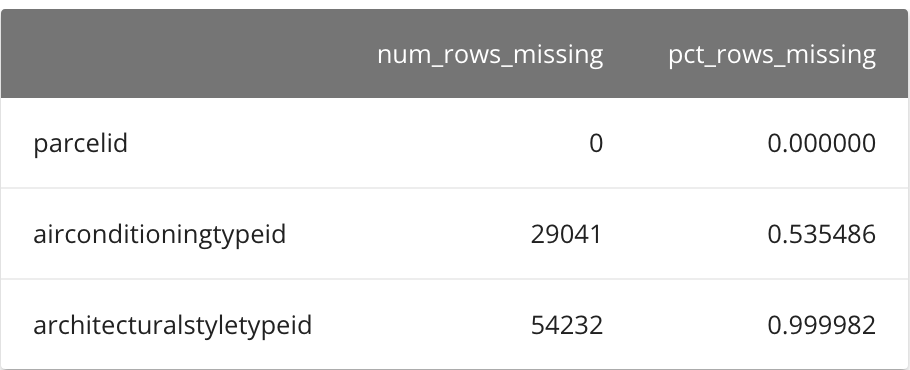

(75575, 33)

### Prep Data Function:

In [8]:
# Function to Prep Data
def data_prep(df, cols_to_remove=[], prop_required_column=.5, prop_required_row=.75):
    
    def remove_columns(df, cols_to_remove):  
        df = df.drop(columns=cols_to_remove)
        return df

    def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
        threshold = int(round(prop_required_column*len(df.index),0))
        df.dropna(axis=1, thresh=threshold, inplace=True)
        threshold = int(round(prop_required_row*len(df.columns),0))
        df.dropna(axis=0, thresh=threshold, inplace=True)
        return df
    
    df = remove_columns(df, cols_to_remove)  # Removes Specified Columns
    df = handle_missing_values(df, prop_required_column, prop_required_row) # Removes Specified Rows
    #df.dropna(inplace=True) # Drops all Null Values From Dataframe
    return df


# How to Call the Function
# df = prepare.data_prep(
#     df,
#     cols_to_remove=[],
#     prop_required_column=.6,
#     prop_required_row=.75
# )